## Use SageMaker Clarify to detect potential biases in a banking marketing dataset.

### Overview of SageMaker Clarify
SageMaker Clarify addresses the critical challenge of bias in ML/AI systems by providing tools for both data bias and model bias detection. It integrates with SageMaker's ecosystem to provide a seamless workflow for responsible ML/AI development.

#### Key capabilities include:

Detecting bias in training data and trained models

Explaining model predictions through feature importance

Monitoring deployed models for bias drift

Supporting tabular, NLP, and computer vision models

Data Bias Detection

In this notebook, SageMaker Clarify offers specific capabilities to identify potential bias during the data preparation phase

In [1]:
!pip install seaborn
!pip install smclarify
from smclarify.bias import report
from typing import Dict
from collections import defaultdict
import pandas as pd
import seaborn as sns

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached smclarify-0.5-py3-none-any.whl.metadata (3.3 kB)
  Using cached pyfunctional-1.5.0-py3-none-any.whl.metadata (40 kB)
Using cached smclarify-0.5-py3-none-any.whl (30 kB)
Using cached pyfunctional-1.5.0-py3-none-any.whl (53 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.28.3 requires faiss-cpu!=1.8.0.post0,<2.0.0,>=1.8.0, which is not installed.
jupyter-scheduler 2.9.0 requires fsspec==2023.6.0, but you have fsspec 2025.7.0 which is incompatible.


Get the [marketing dataset]( https://archive.ics.uci.edu/ml/datasets/bank+marketing). 

In [12]:
# Load the data into DataFrame for analysis
!curl -o bank-additional.zip https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
!unzip -o bank-additional.zip -d /tmp/
!rm -rf bank-additional.zip

local_data_path = '/tmp/bank-additional/bank-additional-full.csv'
df = pd.read_csv(local_data_path)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  422k  100  422k    0     0  2433k      0 --:--:-- --:--:-- --:--:-- 2443k
Archive:  bank-additional.zip
  inflating: /tmp/bank-additional/bank-additional-names.txt  
  inflating: /tmp/bank-additional/bank-additional.csv  
  inflating: /tmp/bank-additional/bank-additional-full.csv  


In [13]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [14]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


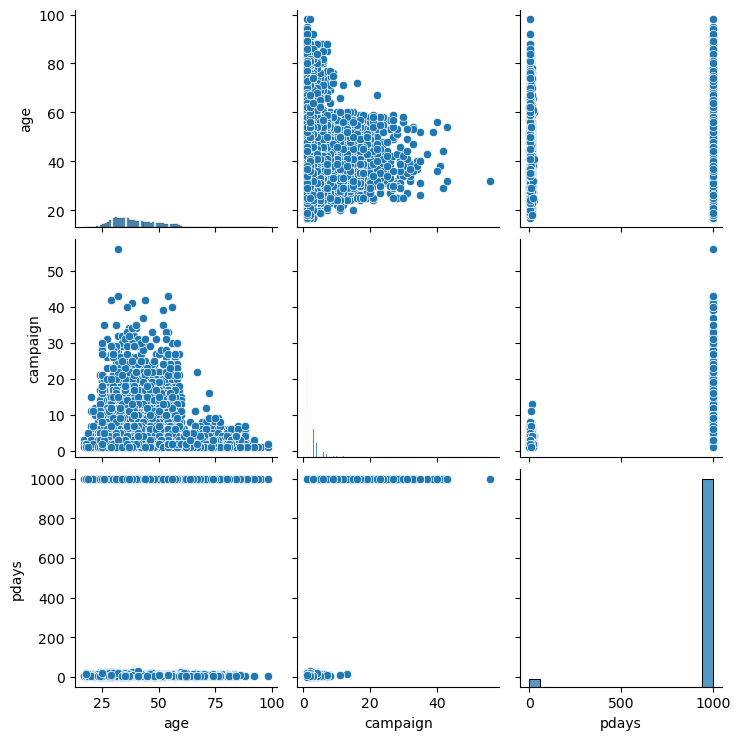

In [15]:
# Create a pairplot that shows the relationships between variables: 'age', 'campaign', and 'pdays'. 
# payday 999 means customer was not previously contacted
sns.pairplot(df[['age','campaign', 'pdays']])

In [16]:
# Discretize the continuous age variable into 3 categories
df['age_disc'] = pd.cut(df.age, bins=3, labels=['young', 'middle', 'old'])
facet_column = report.FacetColumn('age_disc')
label_column = report.LabelColumn(name='y', series=df['y'], positive_label_values=['yes'])


In [17]:
# use defined columns to measure bias
report.bias_report(df, facet_column, label_column, stage_type=report.StageType.PRE_TRAINING, group_variable=df['education'])

[{'value_or_threshold': 'middle',
  'metrics': [{'name': 'CDDL',
    'description': 'Conditional Demographic Disparity in Labels (CDDL)',
    'value': 0.006892056237925899},
   {'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.38987083616587354},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': 0.005325284796874788},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': 3.575237471718177e-05},
   {'name': 'KL',
    'description': 'Kullback-Liebler Divergence (KL)',
    'value': 0.00014401614463265076},
   {'name': 'KS',
    'description': 'Kolmogorov-Smirnov Distance (KS)',
    'value': 0.005325284796874788},
   {'name': 'LP',
    'description': 'L-p Norm (LP)',
    'value': 0.007531089983239568},
   {'name': 'TVD',
    'description': 'Total Variation Distance (TVD)',
    'value': 0.005325284796874781}]},
 {'value_or_threshold': 'young',
  'metrics': [{'name': 'CDDL',
    'descr

### Interpreting the results
The older age group faces the most significant bias in the dataset, with strong evidence across multiple metrics, particularly in representation (CI) and outcomes (DPL). This bias persists even when accounting for education levels.


Middle Age Group:
Low bias indicators overall
Small CDDL (Conditional Demographic Disparity in Labels) (0.007) suggests minimal conditional bias
Moderate CI (Class Imbalance) (0.390) indicates some class imbalance
Very low DPL (Difference in Positive Proportions in Labels) (0.005) shows similar positive outcome proportions
Young Age Group:

Slightly more pronounced but still relatively low bias
Higher CDDL (0.028) than middle age group
Negative CI (-0.372) indicates underrepresentation
Low DPL (0.010) suggests fairly equal positive outcomes
Old Age Group:

Shows significant bias indicators
Negative CDDL (-0.035) indicates disadvantage even when controlling for education
Very high CI (0.982) shows severe class imbalance
Large negative DPL (-0.381) reveals much lower positive outcome rate
Higher divergence metrics (JS: 0.092, KL: 0.334) indicate substantial distributional differences

Key bias metrics and their definitions:

CDDL (Conditional Demographic Disparity in Labels)

Measures bias while accounting for confounding variables (like education)
Shows if disparities persist after controlling for other factors
CI (Class Imbalance)

Measures representation imbalance between groups
Range: -1 to +1 (0 = perfect balance)
Positive values indicate overrepresentation, negative values indicate underrepresentation
DPL (Difference in Positive Proportions in Labels)

Compares the rate of positive outcomes between groups
Shows if certain groups are more/less likely to get positive outcomes
JS (Jensen-Shannon Divergence)

Measures similarity between probability distributions
Range: 0 to 1 (0 = identical distributions)
KL (Kullback-Leibler Divergence)

Measures how one probability distribution differs from another
Larger values indicate greater differences
KS (Kolmogorov-Smirnov Distance)

Maximum difference between cumulative distributions
Range: 0 to 1 (0 = no difference)
TVD (Total Variation Distance)

Measures maximum difference in probabilities between groups
Range: 0 to 1 (0 = identical distributions)
LP (L-p Norm)

Measures the magnitude of differences between distributions
Larger values indicate greater disparity

Recommended strategies to mitigate the detected age bias:

Data Collection & Sampling:

Balanced Representation
Ensure proportional representation of all age groups in marketing campaigns
Implement stratified sampling to maintain age group balance
Collect more data from underrepresented older age groups

Marketing Campaign Adjustments:

Customize Approach by Age
Develop age-appropriate marketing strategies
Adjust contact frequency (noting the lower campaign means for 60+ groups)
Use preferred communication channels for different age groups
Equal Contact Strategy
Standardize number of campaign contacts across age groups
Monitor and adjust contact rates to ensure fairness
Set minimum and maximum contact thresholds
Process Modifications:

Regular Monitoring
Implement continuous bias monitoring
Set bias metric thresholds for alerts
Regular reporting on age distribution metrics
Decision-Making Protocol
Establish clear criteria for campaign inclusion
Create age-neutral selection processes
Document justification for any age-based differences
Training & Awareness:

Staff Training
Train marketing teams on age bias awareness
Develop guidelines for age-inclusive marketing
Regular review of bias metrics and their interpretation
Policy Development
Create explicit policies for age-inclusive marketing
Set standards for balanced age representation
Regular policy review and updates
These strategies should be implemented systematically and their effectiveness monitored through continued bias analysis.


